# Transient neuron dynamics in a spiking GoogLeNet

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

## Settings

In [2]:
from snntoolbox.config import update_setup

settings = {'path_wd': '/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool',
            'dataset_path': '/home/rbodo/.snntoolbox/Datasets/imagenet/GoogLeNet',
            'dataset_format': 'npz',
            'filename_ann': '69.70_89.38',
            'model_lib': 'lasagne',
            'evaluateANN': False,
            'normalize': True,
            'convert': True,
            'simulate': True,
            'simulator': 'INI',
            'duration': 200,
            'dt': 1,
            'batch_size': 1,
            'verbose': 3,
            'num_to_test': 10000,
            'runlabel': 'base',
            'percentile': 99.999,
            'normalization_schedule': False,
            'softmax_to_relu': True,
            'reset': 'Reset by subtraction'
            }

update_setup(settings)

True

## Load network

In [3]:
import keras
from snntoolbox.config import settings

T = int(settings['duration'] / settings['dt'])

path = os.path.join(settings['path_wd'], 'log', 'debug', settings['runlabel'])
model = keras.models.load_model(os.path.join(settings['path_wd'], settings['filename_parsed_model'] + '.h5'))
parameters = model.get_weights()
weights = parameters[::2]
biases = parameters[1:-1:2]
layer_labels = [layer.name for layer in model.layers if 'Conv' in layer.name or 'Dense' in layer.name]
input_shape = model.layers[0].input_shape
biases_flat = []
for b in biases:
    biases_flat += list(b)
biases_flat = np.array(biases_flat)

Using Theano backend.


Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


## Define plotting functions

In [4]:
def get_rates_t(spiketrains_batch):
    spikerates_batch = []
    for spiketrains_layer in spiketrains_batch:
        label = spiketrains_layer[1]
        spiketrains = spiketrains_layer[0]
        spikerates_t = np.zeros_like(spiketrains)
        count = np.zeros(spiketrains.shape[:-1])
        t_idx = 0
        for t in np.arange(0, settings['duration'], settings['dt']):
            count += spiketrains[Ellipsis, t_idx] > 0
            spikerates_t[Ellipsis, t_idx] = count/(t+settings['dt'])
            t_idx += 1
        spikerates_batch.append((spikerates_t, label))
    return spikerates_batch


def plot_spikerates(spikerates_batch, labels, target_activations=None, filename='spikerates', path=settings['log_dir_of_current_run']):
    plt.title('Spike-rates')
    plt.xlabel('Simulation time')
    plt.ylabel('Spike-rate')
    plt.ylim(0, 1)
    colors = plt.cm.plasma(np.linspace(0, 0.9, len(spikerates_batch)))
    for i, spikerates in enumerate(spikerates_batch):
        plt.plot(np.arange(0, settings['duration'], settings['dt']), spikerates, label=labels[i], color=colors[i])
        if target_activations is not None:
            plt.plot([0, settings['duration']], [target_activations[i], target_activations[i]], label='{}_target'.format(labels[i]), color=colors[i])
    #plt.legend(loc='center right')
    plt.savefig(os.path.join(path, filename), bbox_inches='tight')


def plot_mean_std(mean, std, title, ylabel):
    plt.title(title)
    plt.xlabel('Layer index')
    plt.ylabel(ylabel)
    plt.plot(mean)
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.1, color='blue')
    plt.plot([0, len(mean)], [0, 0], 'black')
    plt.savefig(os.path.join(path, title.replace(' ', '_')), bbox_inches='tight')


def plot_spiketrains(spiketrains_fm, label):
    plt.figure(figsize=(15, 8))
    plt.xlabel('t')
    plt.title('Spiketrains of a feature map in layer {}'.format(label))
    plt.ylabel('Neuron index')
    for (neuron, spiketrain) in enumerate(spiketrains_fm):
        spikelist = [j for j in spiketrain if j != 0]
        y = np.ones_like(spikelist) * neuron
        plt.plot(spikelist, y, '.', markersize=1)
    plt.savefig(os.path.join(path, 'spiketrains_{}'.format(label)), bbox_inches='tight')

## Load measured spiketrains and ANN activations

In [41]:
spiketrains_batch = np.load(os.path.join(settings['log_dir_of_current_run'], 'spiketrains', '0.npz'))['spiketrains']
target_rates_all = np.load(os.path.join(settings['log_dir_of_current_run'], 'activations', '0.npz'))['activations']
target_rates = [tr for tr in target_rates_all if 'Conv' in tr[1]]

## Compute spike-rates

In [6]:
spikerates_all = get_rates_t(spiketrains_batch)
spikerates_batch = [sr for sr in spikerates_all if 'Conv' in sr[1]]

## Compute mean weights

In [7]:
mean_weights = []
for layer in model.layers:
    if 'Conv' not in layer.name:
        continue
    l = layer.from_config(layer.get_config())
    l.activation = keras.activations.linear
    l.batch_input_shape = layer.input_shape
    m = keras.models.Sequential([l])
    m.set_weights([layer.get_weights()[0], np.zeros_like(layer.get_weights()[1])])
    mean_weights.append(m.predict(np.ones(layer.input_shape))[0][:, 0, 0])

mean_weights_flat = []
for mw in mean_weights:
    mean_weights_flat += list(mw)
mean_weights_flat = np.array(mean_weights_flat)

In [8]:
w_mean = np.array([np.mean(mw) for mw in mean_weights])
w_var = np.array([np.var(mw) for mw in mean_weights])
w_std = np.array([np.std(mw) for mw in mean_weights])
b_mean = np.array([np.mean(b) for b in biases])
b_var = np.array([np.var(b) for b in biases])
b_std = np.array([np.std(b) for b in biases])

## Compute net input

In [9]:
net_input = []
for layer in model.layers:
    if 'Conv' not in layer.name:
        continue
    l = layer.from_config(layer.get_config())
    l.activation = keras.activations.linear
    l.batch_input_shape = layer.input_shape
    m = keras.models.Sequential([l])
    m.set_weights(layer.get_weights())#[layer.get_weights()[0], np.zeros_like(layer.get_weights()[1])])
    out = []
    for i in range(10):
        out.append(m.predict(np.random.randint(2, size=layer.input_shape))[0])
    net_input.append(np.array(out))

ni_mean = np.array([np.mean(ni) for ni in net_input])
ni_var = np.array([np.var(ni) for ni in net_input])
ni_std = np.array([np.std(ni) for ni in net_input])

net_input_f = np.array([np.mean(ni, (0, 2, 3)) for ni in net_input])
net_input_f_flat = []
for ni in net_input_f:
    net_input_f_flat += list(ni)
net_input_f_flat = np.array(net_input_f_flat)

## Possible criteria for transients

### 1. Biases

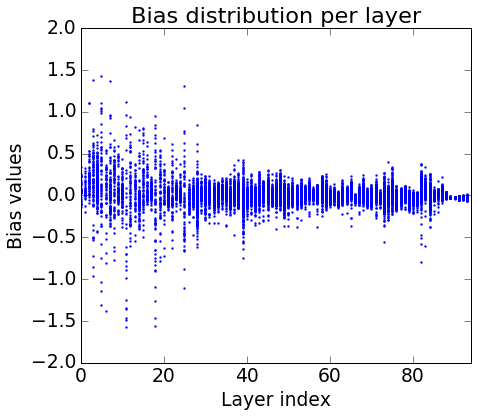

In [10]:
plt.title('Bias distribution per layer')
plt.xlabel('Layer index')
plt.ylabel('Bias values')
plt.xlim(0, len(biases))
for i, b in enumerate(biases):
    plt.scatter(np.ones(len(b)) * i, b, marker='.', edgecolors='blue', linewidths=0.1)
plt.savefig(os.path.join(path, 'Bias_distribution_per_layer_scatter'), bbox_inches='tight')

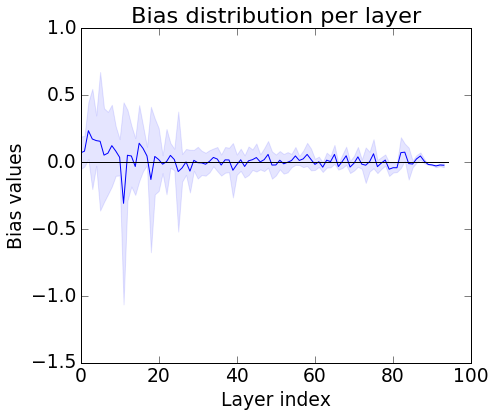

In [11]:
plot_mean_std(b_mean, b_std, 'Bias distribution per layer', 'Bias values')

### 2. Mean weights

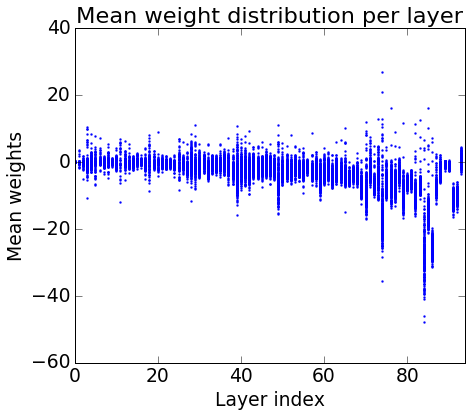

In [12]:
plt.title('Mean weight distribution per layer')
plt.xlabel('Layer index')
plt.ylabel('Mean weights')
plt.xlim(0, len(mean_weights))
for i, mw in enumerate(mean_weights):
    plt.scatter(np.ones(len(mw)) * i, mw, marker='.', edgecolors='blue', linewidths=0.1)
plt.savefig(os.path.join(path, 'Mean_weight_distribution_per_layer_scatter'), bbox_inches='tight')

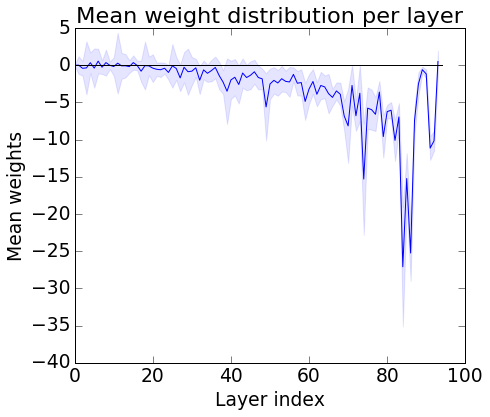

In [13]:
plot_mean_std(w_mean, w_std, 'Mean weight distribution per layer', 'Mean weights')

### 3. Net input

For each layer, draw a spike sample from a binary distribution, and feed it into the layer. Given this input, compute the net input that each neuron receives. Average over 10 samples.

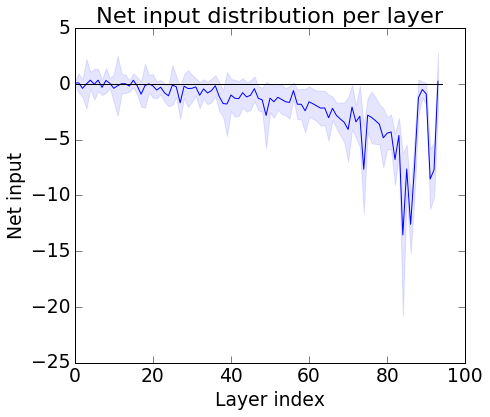

In [14]:
plot_mean_std(ni_mean, ni_std, 'Net input distribution per layer', 'Net input')

The result is equivalent to the mean input (note that we include biases here). I.e. random firing has a similar effect as all inputs firing.

Fraction of ANN neurons with positive input: 6.15%
Fraction of SNN neurons with positive input: 0.84%
Fraction of ANN feature maps with positive input: 76.04%
Fraction of SNN feature maps with positive input : 1.04%
Key: Layer index; value: Fraction of neurons with positive input: {'304': 1.0, '366': 1.0, '109': 0.8125, '37': 0.421875}


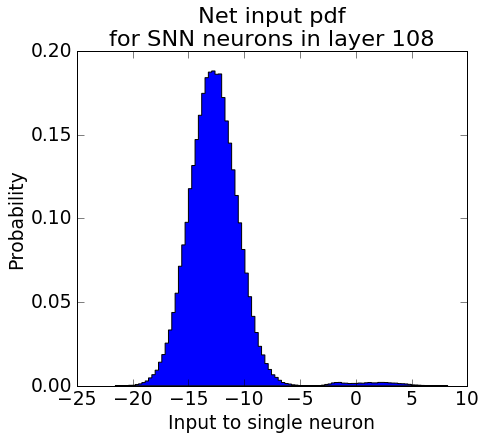

In [15]:
plt.hist(net_input[86].flatten(), 100, histtype='stepfilled', normed=True);
plt.title('Net input pdf\nfor SNN neurons in layer 108')
plt.xlabel('Input to single neuron')
plt.ylabel('Probability')
plt.savefig(os.path.join(path, 'net_input_pdf_108'), bbox_inches='tight')

trf = target_rates[86][0][0]
nif = net_input[86][0]
trf_pos = trf[np.nonzero(trf > 0)]
nif_pos = nif[np.nonzero(nif > 0)]
fm_frac_pos_input = {str(i): np.count_nonzero(ni > 0) / np.prod(nif[0].shape) for i, ni in enumerate(nif) if np.count_nonzero(ni > 0) > 0}
print("Fraction of ANN neurons with positive input: {:.2%}".format(len(trf_pos) / np.size(trf)))
print("Fraction of SNN neurons with positive input: {:.2%}".format(len(nif_pos) / np.size(nif)))
print("Fraction of ANN feature maps with positive input: {:.2%}".format(np.count_nonzero(np.any(trf, (1, 2))) / len(trf)))
print("Fraction of SNN feature maps with positive input : {:.2%}".format(len(fm_frac_pos_input) / len(trf)))
print("Key: Layer index; value: Fraction of neurons with positive input: {}".format(fm_frac_pos_input))

These two measures (mean weights, and net input) give no accurate indication of what each neuron should receive in a real, converged simulation. The whole point in training the network is that the input to a neuron is neither given by all input units firing together, nor by a randomly drawn spike sample. It is rather highly specific. To illustrate, the previous plot shows the net input to neurons in layer 108. In the ANN layer (representing ground truth), 76 % of feature maps receive positive input. In contrast, only 4 out of 384 feature maps get positive input in the SNN layer, when stimulated with a random sample. The reason for this becomes obvious when viewing the probability distribution above. So a deviation from the desired input (represented by randomizing the input) can have a large effect on the net input seen by the units in a layer.

## How to measure transients

### Plot convergence of spike-rates

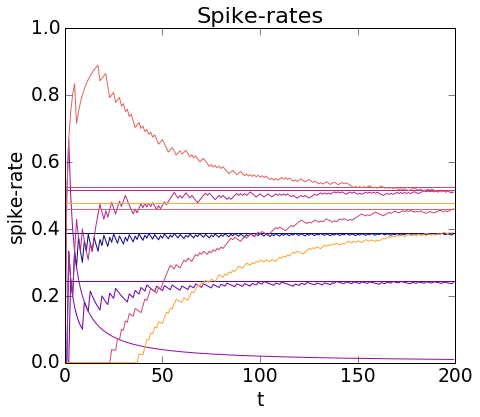

In [16]:
sr = [s[0][0, 0, 0, 0] for s in spikerates_batch[:10]]
tr = [t[0][0, 0, 0, 0] for t in target_rates[:10]]
labels = [sr[1] for sr in spikerates_batch[:10]]
plot_spikerates(sr, labels, tr, 'spikerates', path);

### Compute the time of convergence

In [17]:
interval = 0.1
conv_times_all = []
for i in range(len(spikerates_all)):
    spikerates_t = spikerates_all[i][0]
    targets = target_rates_all[i][0]
    lim_up = targets + interval / 2
    lim_down = targets - interval / 2
    near_target_t = np.zeros_like(spikerates_t)
    for t in range(T):
        near_target_t[Ellipsis, t] = np.logical_and(lim_up > spikerates_t[Ellipsis, t], spikerates_t[Ellipsis, t] >= lim_down)
    conv_count = np.cumsum(near_target_t, -1)
    out = np.argmax(np.array(conv_count == 3), -1)
    out[out == 0] = T + 1  # At this point, zero means no convergence. Replace by a value beyond the simulation duration.
    out -= 2  # Shift all values so that lowest convergence time lies at origin. 
    conv_times_all.append((out, spikerates_all[i][1]))

# Get only convolution layers
conv_times = [ct for ct in conv_times_all if 'Conv' in ct[1]]

### Compute averages of convergence time per feature and per layer

In [18]:
# Convergence times averaged over features
conv_times_f = []
for i in range(len(conv_times)):
    num_nonzero = np.array([np.count_nonzero(c) for c in conv_times[i][0][0]])
    num_nonzero[num_nonzero == 0] = 1
    conv_times_f.append((np.sum(conv_times[i][0], (2, 3)) / num_nonzero, conv_times[i][1]))
    # conv_times_f == [([convergence times per feature], layer label), (...)]

# Remove layer grouping to get convergence times per feature in 1D list.
conv_times_f_flat = []
for c in conv_times_f:
    conv_times_f_flat += list(c[0][0])
conv_times_f_flat = np.array(conv_times_f_flat)

# Convergence times averaged over layers
conv_times_l = []
for i in range(len(conv_times)):
    conv_times_l.append((np.mean(conv_times_f[i][0]), conv_times_f[i][1]))
    # conv_times_l == [([convergence times per layer], layer label), (...)]

# Remove layer labels to get convergence times per layer in 1D list
conv_times_l_flat = np.array([c[0] for c in conv_times_l])

# Put layer convergence times in dictionary for efficient access by label
conv_times_l_dict = {ctl[1]: ctl[0] for ctl in conv_times_l}

### Plot distribution of convergence times

#### Layer average:

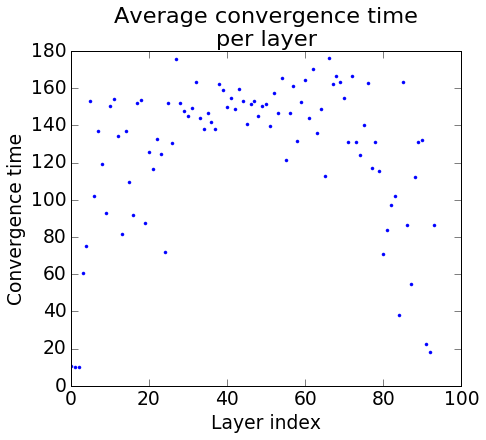

In [19]:
plt.plot(conv_times_l_flat, '.')
plt.title("Average convergence time\nper layer")
plt.xlabel("Layer index")
plt.ylabel("Convergence time");
plt.savefig(os.path.join(path, 'avg_ct_l'), bbox_inches='tight')

When presenting the network with a random sample instead of an image from the test set, the figure looks almost the same, except for higher convergence times in the first few layers. This indicates that errors accumulating across layers manifest themselves as noise in higher parts of the network.

In [20]:
conv_times_l[:12]

[(10.867145906953205, '00Convolution2D_32x149x149'),
 (9.8421578713613513, '01Convolution2D_32x147x147'),
 (10.025725352899222, '02Convolution2D_64x147x147'),
 (60.727462022519923, '04Convolution2D_80x73x73'),
 (75.013042261317523, '05Convolution2D_192x71x71'),
 (152.96994846973581, '10Convolution2D_64x35x35'),
 (102.08037071485235, '08Convolution2D_48x35x35'),
 (136.99638465891618, '11Convolution2D_96x35x35'),
 (119.46185803377966, '07Convolution2D_64x35x35'),
 (93.047131503136001, '09Convolution2D_64x35x35'),
 (150.63381485110003, '12Convolution2D_96x35x35'),
 (154.19948275916897, '14Convolution2D_32x35x35')]

Note that the steep rise in convergence time begins with the first convolution layers that has 1x1 kernels (index 4). Does the pattern repeat for later layers?

### Plot increase in convergence time vs kernel size

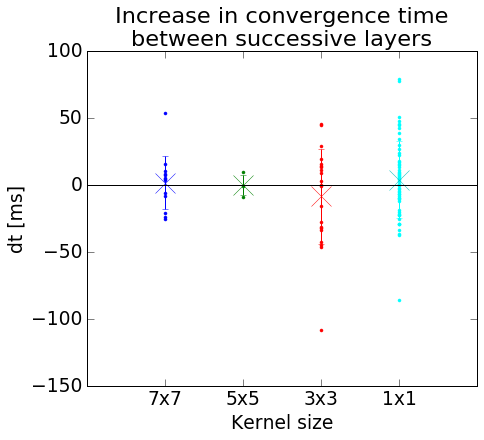

In [21]:
from snntoolbox.core.util import get_inbound_layers_with_params
diffCT = {'1': [], '3': [], '5': [], '7': []}
for layer in model.layers:
    if 'Conv' not in layer.name:
        continue
    inbound_layers = get_inbound_layers_with_params(layer)
    if len(inbound_layers) > 1:
        ct_prev = np.mean([conv_times_l_dict[inb.name] for inb in inbound_layers])
    if len(inbound_layers) < 1:
        ct_prev = 0
    else:
        ct_prev = conv_times_l_dict[inbound_layers[0].name]
    diffCT[str(layer.nb_col)].append(conv_times_l_dict[layer.name] - ct_prev)

diffCT_mean = {}
diffCT_std = {}
colors = ['blue', 'green', 'red', 'cyan']
for i, key in enumerate(['7', '5', '3', '1']):
    diffCT_mean[key] = np.mean(diffCT[key])
    diffCT_std[key] = np.std(diffCT[key])
    plt.plot(np.ones(len(diffCT[key])) * (i + 1), diffCT[key], '.', color=colors[i])
    plt.errorbar(i + 1, diffCT_mean[key], yerr=diffCT_std[key], fmt='x', ecolor=colors[i], markersize=20)
    plt.plot([0, 5], [0, 0], color='black')
plt.title("Increase in convergence time\nbetween successive layers")
plt.xlabel("Kernel size")
plt.ylabel("dt [ms]")
plt.xlim(0, 5)
plt.xticks([1, 2, 3, 4], ['7x7', '5x5', '3x3', '1x1']);
plt.savefig(os.path.join(path, 'increase_ct_l'), bbox_inches='tight')

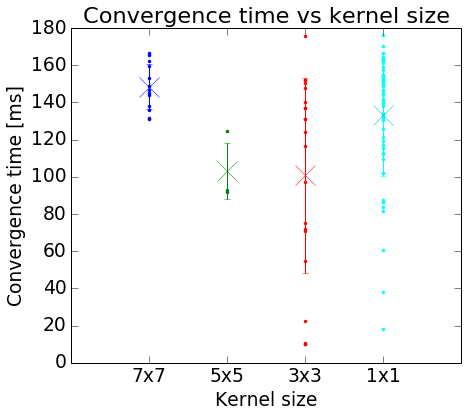

In [22]:
absCT = {'1': [], '3': [], '5': [], '7': []}
for layer in model.layers:
    if 'Conv' not in layer.name:
        continue
    absCT[str(layer.nb_col)].append(conv_times_l_dict[layer.name])

absCT_mean = {}
absCT_std = {}
colors = ['blue', 'green', 'red', 'cyan']
for i, key in enumerate(['7', '5', '3', '1']):
    absCT_mean[key] = np.mean(absCT[key])
    absCT_std[key] = np.std(absCT[key])
    plt.plot(np.ones(len(absCT[key])) * (i + 1), absCT[key], '.', color=colors[i])
    plt.errorbar(i + 1, absCT_mean[key], yerr=absCT_std[key], fmt='x', ecolor=colors[i], markersize=20)
plt.title("Convergence time vs kernel size")
plt.xlabel("Kernel size")
plt.ylabel("Convergence time [ms]")
plt.xlim(0, 5)
plt.xticks([1, 2, 3, 4], ['7x7', '5x5', '3x3', '1x1']);
plt.savefig(os.path.join(path, 'ct_kernel'), bbox_inches='tight')

### Plot convergence times averaged over feature maps

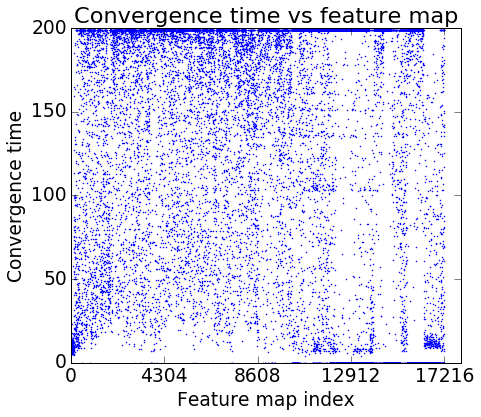

In [23]:
plt.plot(np.arange(0, len(conv_times_f_flat)), conv_times_f_flat, '.', markersize=2)
plt.title('Convergence time vs feature map')
plt.xlabel('Feature map index')
plt.ylabel('Convergence time')
plt.xticks(np.linspace(0, len(conv_times_f_flat), 5));
plt.savefig(os.path.join(path, 'ct_f'), bbox_inches='tight')

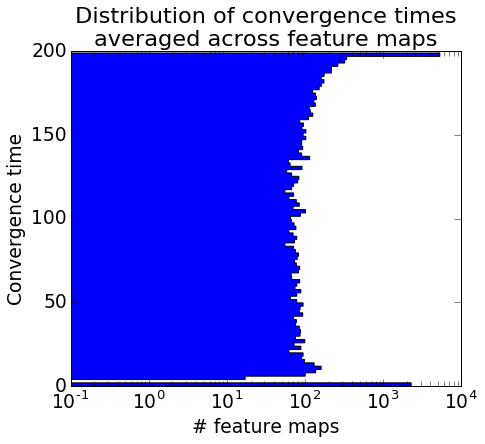

In [24]:
plt.hist(conv_times_f_flat, 100, histtype='stepfilled', log=True, orientation='horizontal');
plt.title("Distribution of convergence times\naveraged across feature maps")
plt.ylabel("Convergence time")
plt.xlabel("# feature maps");
plt.savefig(os.path.join(path, 'ct_f_distribution'), bbox_inches='tight')

The bar at the very top (at 200 ms) represents feature maps that have not converged yet. 

### Plot distribution of feature maps wrt the fraction of neurons that has not converged

Observation: Failure to converge is a phenomenon that tends to affect feature maps as a whole. A very high number of feature maps do not converge at all. An even larger part is simply quiescent and can be neglected. In the remaining few feature maps, various degrees of convergence is observed. This supports the view that biases are responsible for transients. 

## Correlation between measure of transients (convergence time) and possible predictors

### Convergence time vs bias

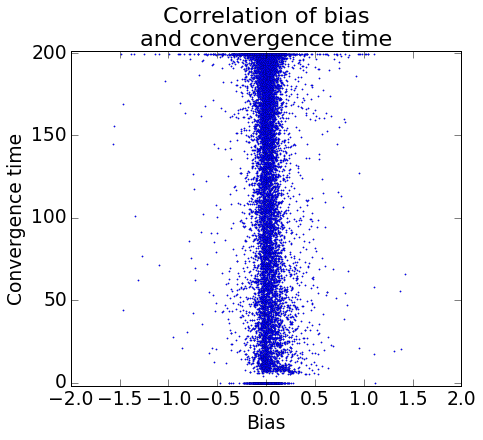

In [25]:
plt.scatter(biases_flat, conv_times_f_flat, s=10, linewidths=0.1, marker='.')
plt.title('Correlation of bias\nand convergence time')
plt.ylabel('Convergence time')
plt.xlabel('Bias')
plt.ylim(-2, T + 1);
plt.savefig(os.path.join(path, 'corr_ct_b'), bbox_inches='tight')

No clear correlation: A given bias value can be associated with any possible convergence time.

As we will see below, a single bias outlier can cause an avalanche of errors in subsequent layers even though the feature map it belongs to converges within 5 time steps.

### Convergence time vs mean weights

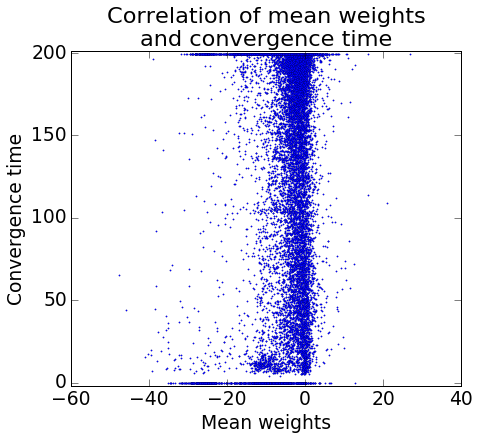

In [26]:
plt.scatter(mean_weights_flat, conv_times_f_flat, s=10, linewidths=0.1, marker='.')
plt.title('Correlation of mean weights\nand convergence time')
plt.ylabel('Convergence time')
plt.xlabel('Mean weights')
plt.ylim(-2, T + 1);
plt.savefig(os.path.join(path, 'corr_ct_mean_weights'), bbox_inches='tight')

Again no clear conclusion can be drawn. Negative weights are more common, but account for very low convergence times as much as for very high ones.

### Convergence time vs net input

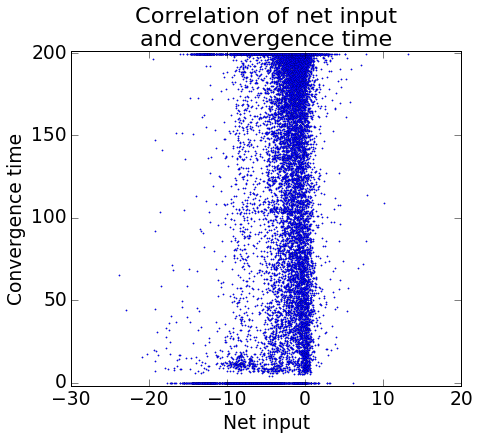

In [27]:
plt.scatter(net_input_f_flat, conv_times_f_flat, s=10, linewidths=0.1, marker='.')
plt.title('Correlation of net input\nand convergence time')
plt.ylabel('Convergence time')
plt.xlabel('Net input')
plt.ylim(-2, T + 1);
plt.savefig(os.path.join(path, 'corr_ct_net_input'), bbox_inches='tight')

### Correlation between convergence time and target rates

In [28]:
layer_idx = 3  # 04Convolution2D_80x73x73
feature_idx = 6
ct = conv_times[layer_idx][0][0]  # Convergence times of a given layer and first sample
ctf = ct[feature_idx]  # Convergence times of a given feature map
tr = target_rates[layer_idx][0][0]
trf = tr[feature_idx]

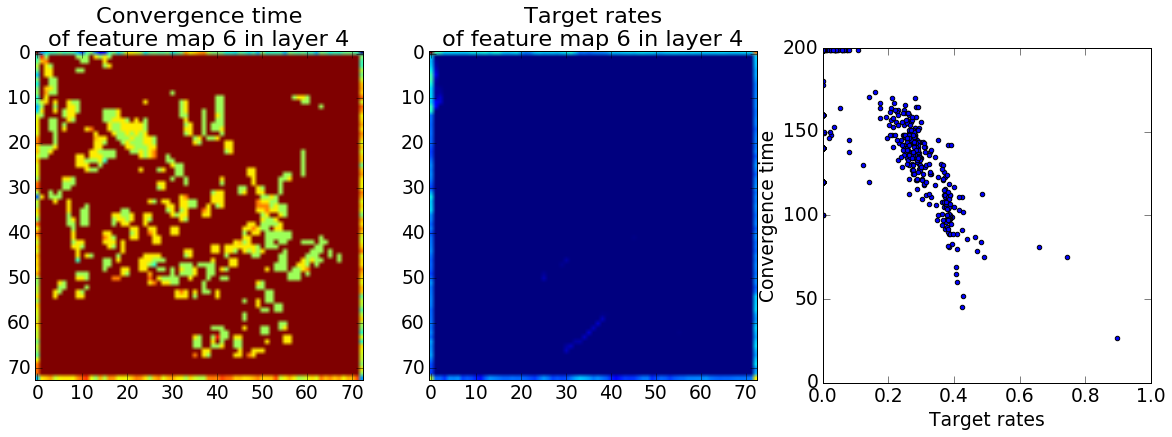

In [29]:
f, ax = plt.subplots(1, 3)
f.set_figwidth(20)
ax[0].imshow(ctf)
ax[1].imshow(trf)
ax[2].scatter(trf, ctf)
ax[0].set_title("Convergence time\nof feature map 6 in layer 4")
ax[1].set_title("Target rates\nof feature map 6 in layer 4")
ax[2].set_xlabel("Target rates")
ax[2].set_ylabel("Convergence time")
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, T);
f.savefig(os.path.join(path, 'corr_ct_activations'), bbox_inches='tight')

In the first two layers, convergence is very good, the correlation flat.

Starting with layer 4 (04Convolution2D80x73x73), we observe a negative correlation: High frequencies are approximated better, as expected. This layer is the first to introduce notable errors due to difficulties of encoding low frequency values. Feature map 6 is an example of bad convergence. Interestingly, there is a high outlier in the weight distribution (see Figure below). With a value of 4.81, it is larger than the next highest weight by an order of magnitude. Since it is a 1x1 convolution layer, this single outlier weights the input of an entire presynaptic feature map (namely feature map 29 in layer 3). A single wrong input spike from this feature map would outweight all other inputs and offset the membrane potential by a multiple of the threshold. Presumably, most neurons of the presynaptic feature map 29 corresponding to this outlier were spiking wrongly, which caused this postsynaptic feature map 6 to fail to converge. Indeed, the activity of feature map 29 in the SNN layer 03AveragePooling2D_64x73x73 is slightly nonzero, whereas the original ANN feature map is completely quiescent. The activity in this presynaptic SNN feature map 29 corresponds exactly to the postsynaptic convergence-time heat-map of feature map 6 (See Figure further below).

In layer index 5 (10Convolution2D_64x35x35), entire feature maps fail to converge (e.g. the first and last). Their biases and weight distributions show nothing special. The errors now come from so many different feature maps that they cannot be attributed to a single connection.

This polarization increases in higher layers, where we observe an all-or-nothing behavior: Neurons either converge immediately or not at all. Rarely, a few intermediate values are observed too.

Value of bias: -0.10
Value of outlier weigth: 4.81
Index of input feature map corresponding to outlier weight: 29


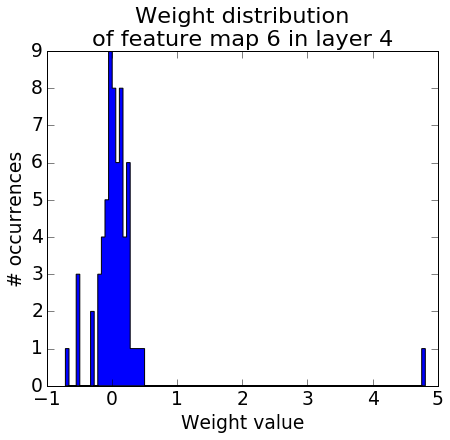

In [10]:
plt.hist(weights[layer_idx][feature_idx].flatten(), 100, histtype='stepfilled');
plt.title("Weight distribution\nof feature map 6 in layer 4")
plt.xlabel("Weight value")
plt.ylabel("# occurrences")
print("Value of bias: {:.2f}".format(biases[layer_idx][feature_idx]))
print("Value of outlier weigth: {:.2f}".format(np.max(weights[layer_idx][feature_idx])))
print("Index of input feature map corresponding to outlier weight: {}".format(np.argmax(weights[layer_idx][feature_idx].flatten())))
plt.savefig(os.path.join(path, 'distribution_weights_4'), bbox_inches='tight')

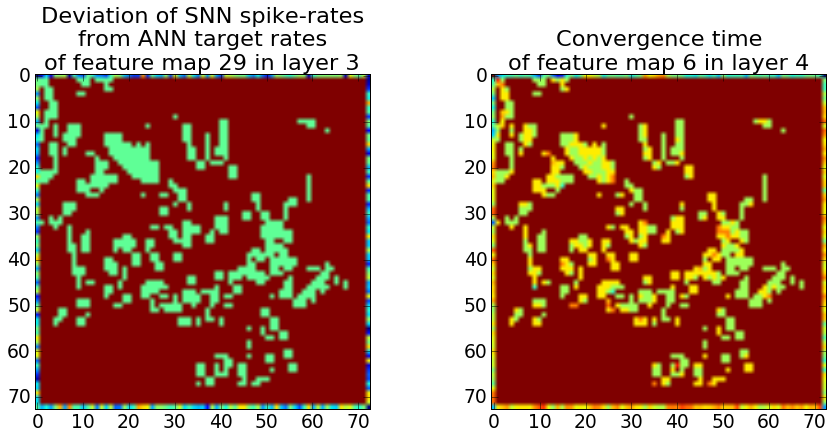

In [31]:
f, (ax0, ax1) = plt.subplots(1, 2)
f.set_figwidth(15)
ax0.imshow(spikerates_all[3][0][0, 29, :, :, -1] - target_rates_all[3][0][0, 29])  # 03AveragePooling2D_64x73x73
ax1.imshow(ctf)  # 04Convolution2D_80x73x73
ax0.set_title("Deviation of SNN spike-rates\nfrom ANN target rates\nof feature map 29 in layer 3")
ax1.set_title("Convergence time\nof feature map 6 in layer 4");
f.savefig(os.path.join(path, 'ct_rate-dev_3'), bbox_inches='tight')

In the left plot, larger deviations are hotter. In the right plot, longer convergence times are hotter.

The SNN shows a pattern of activity that should not be there (red in left plot). The postsynaptic neurons in the subsequent layer that are connected to the erroneously firing neurons by the outlier weight 4.81 do not converge at all (red in right plot).

The erroneous activity in this feature map can be traced back easily: Because the layer in question is an average pooling layer, we can simply look at the corresponding feature map in the previous layer.

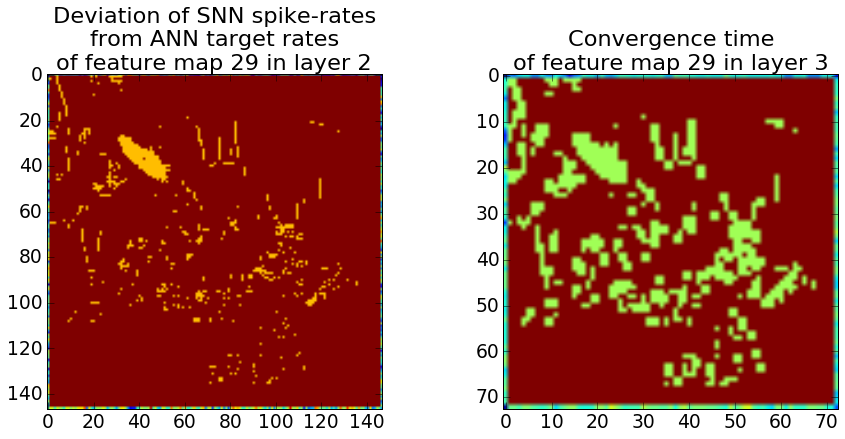

In [32]:
f, (ax0, ax1) = plt.subplots(1, 2)
f.set_figwidth(15)
ax0.imshow(spikerates_batch[2][0][0, 29, :, :, -1] - target_rates[2][0][0, 29])  # 02Convolution2D_64x147x147
ax1.imshow(conv_times_all[3][0][0][29])  # 03AveragePooling2D_64x73x73
ax0.set_title("Deviation of SNN spike-rates\nfrom ANN target rates\nof feature map 29 in layer 2")
ax1.set_title("Convergence time\nof feature map 29 in layer 3")
f.savefig(os.path.join(path, 'ct_rate-dev_2'), bbox_inches='tight')

Again, there is an erroneous activity in the presynaptic SNN feature map, that corresponds exactly to the failure of postsynaptic neurons to converge.

The erroneous spike-rate of neurons in layer 2 is 0.015. With a simulation duration of 200, this corresponds to 3 fired spikes. Our hypothesis is that they occur early in the simulation, when presynaptic neurons have not yet settled at their steady state.

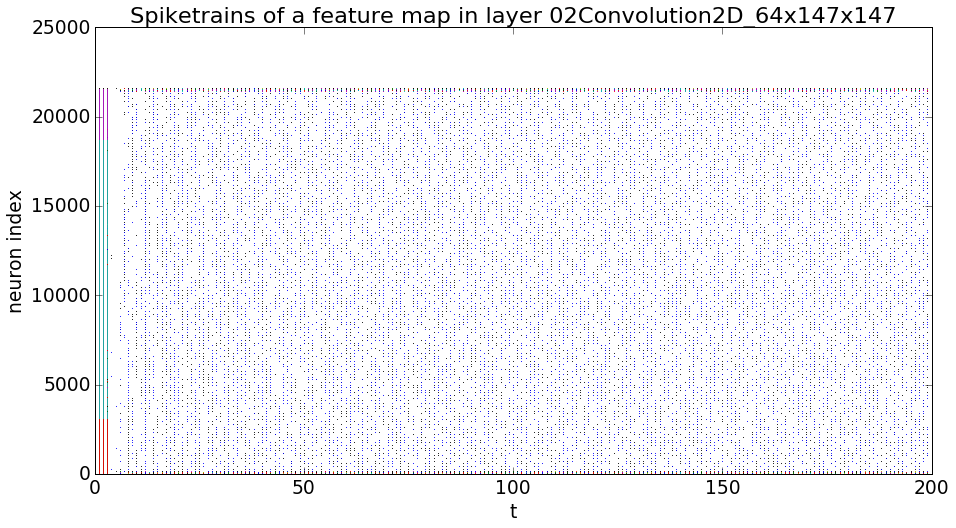

In [33]:
plot_spiketrains(np.reshape(spiketrains_batch[2][0][0, 29], (-1, T)), spiketrains_batch[2][1])

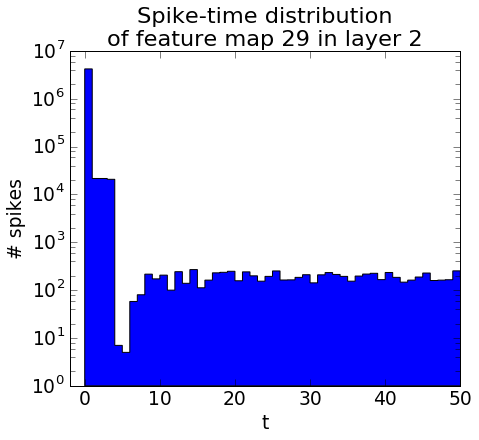

In [34]:
plt.hist(spiketrains_batch[2][0][0, 29].flatten(), 200, histtype='stepfilled', log=True, bottom=1)
plt.xlim(-2, 50)
plt.title('Spike-time distribution\nof feature map 29 in layer 2')
plt.xlabel('t')
plt.ylabel('# spikes');
plt.savefig(os.path.join(path, 'distribution_spiketimes_2'), bbox_inches='tight')

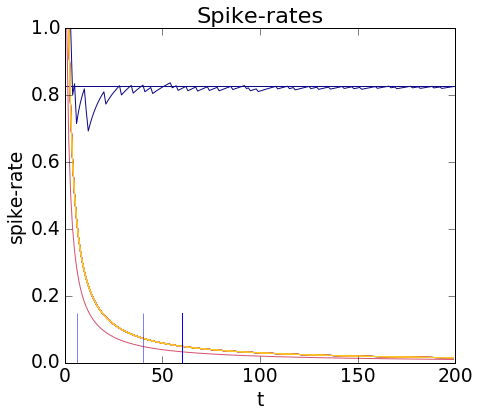

In [35]:
sr = np.reshape(spikerates_batch[2][0][0, 29], (-1, T))
labels = np.array([str(i) for i in range(len(sr))])
idxs = np.arange(0, 21000, 1000)
plot_spikerates(sr[idxs], labels[idxs], target_rates[2][0][0][29].flatten()[idxs])
x = conv_times[2][0][0][29].flatten()[idxs]
plt.plot(x, [0 for i in range(len(x))], '|', markersize=100.);
plt.savefig(os.path.join(path, 'spikerates_2'), bbox_inches='tight')

The above plots confirm that the erroneous activity is caused by three spikes that occur within the first 3 timesteps of the simulation.

These three spikes can be caused by two mechanisms:
1.) A spike-driven excitatory input that adds to a positive bias or is large enough to compensate for a negative bias.
2.) A large positive bias in the absence of inhibitory input.

We find that the bias corresponding to this feature map is indeed an outlier:

Value of outlier bias: 1.11
Index of input feature map corresponding to outlier bias: 29


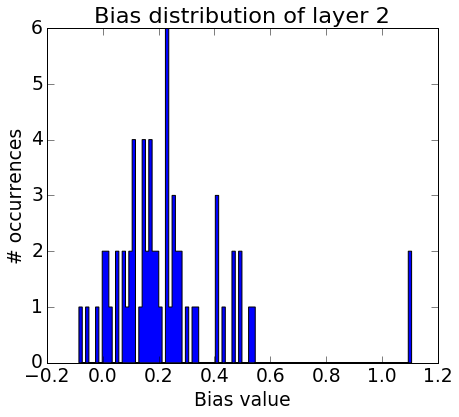

In [36]:
plt.hist(biases[2], 100, histtype='stepfilled')
plt.title("Bias distribution of layer 2")
plt.xlabel("Bias value")
plt.ylabel("# occurrences")
print("Value of outlier bias: {:.2f}".format(np.max(biases[2])))
print("Index of input feature map corresponding to outlier bias: {}".format(np.argmax(biases[2])));
plt.savefig(os.path.join(path, 'distribution_b_2'), bbox_inches='tight')

It remains to be shown that this large bias was not compensated by spike-driven inhibitory input to the neurons in the feature map of layer 2 during the first 3 time steps.

In [37]:
# Confirm that we are looking at a group of neurons that fire three spikes in the beginning:
spikerates_batch[2][0][0, 29, 98:103, 98:103, -1]

array([[ 0.015,  0.015,  0.015,  0.015,  0.015],
       [ 0.015,  0.015,  0.015,  0.015,  0.015],
       [ 0.015,  0.015,  0.015,  0.015,  0.015],
       [ 0.015,  0.015,  0.015,  0.015,  0.015],
       [ 0.015,  0.015,  0.015,  0.015,  0.015]], dtype=float32)

In [44]:
# Compute input to neuron (100, 100) over time
layer = model.layers[3]  # 02Convolution2D_64x147x147
l = layer.from_config(layer.get_config())
l.activation = keras.activations.linear
l.batch_input_shape = layer.input_shape
m = keras.models.Sequential([l])
m.set_weights(layer.get_weights())
input_t = []
for t in range(T):
    input_t.append(m.predict(spiketrains_batch[1][0][:, :, :, :, t])[0, 29, 100, 100])

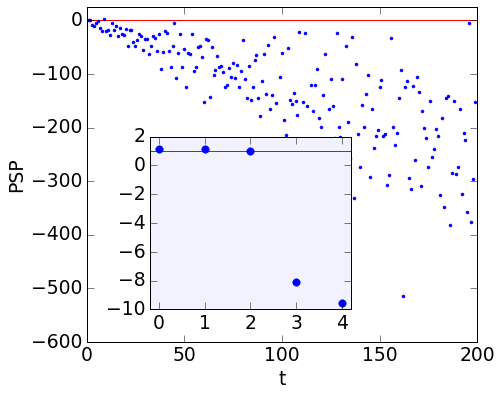

In [86]:
# Plot the input over time
plt.plot(input_t, '.')
plt.hlines(1, 0, T, color='red')
plt.ylim(None, 25)
plt.xlabel('t')
plt.ylabel('PSP')
a = plt.axes([.25, .2, .4, .4], axisbg=(0.95, 0.95, 1))
plt.plot(input_t[:5], '.', markersize=15)
plt.hlines(1, -0.2, 4.2, color='red')
plt.xlim(-0.2, 4.2)
# plt.title('PSPs of a neuron in feature map 29 of layer 2')
plt.savefig(os.path.join(path, 'input_t'), bbox_inches='tight')

In the Figure above, the dots represent input values to neuron (100, 100) in feature map 29 of layer 2 over time. The red line marks the threshold. The plot shows a clear trend towards IPSPs, i.e. the spike-driven input is more strongly inhibitory than the bias is excitatory. This is desired because the target activity of this neuron is 0. However, during the first three time steps of the simulation, the spike-driven input is unable to pull the PSP to values below threshold, and the neuron fires 3 spikes due to its large bias and lacking inhibitory input. During the first 2 time steps, the PSP equals exactly the bias (1.11), meaning that no input spikes arrived. At the third time step it is lowered only slightly to 1.01, which is still above threshold. The missing input spikes are visualized in the spike-time distribution of layer 1: There are no spikes during the first 2 time steps, and only 11 spikes in the whole layer at the third time step. This low activity is understandable in light of two facts: First, the largest bias in layer 1 is 0.327, which by itself is not enough to cross threshold in 3 time steps. Second, the spike input coming from layer 0 is similarly low: No spikes at all during the first 2 time steps, and less than 0.1% of the neurons firing at the third time step. Layer 0 does not fire spikes early during the simulation because the parameters have been normalized such that there can be at most one spike per time step. For a given sample, this maximum rate might not be achieved. During the few time steps needed to accumulate enough input for a spike, the subsequent layer is driven by its bias.

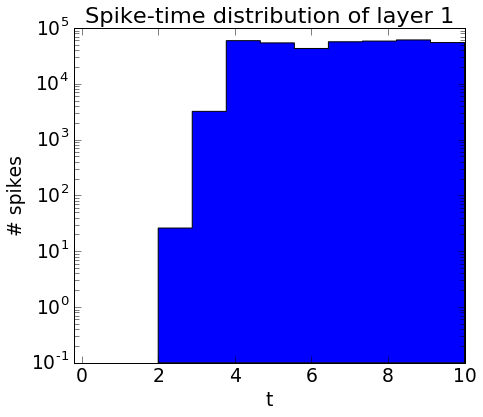

In [40]:
spikelist = [j for j in spiketrains_batch[1][0][0, :, :, :, :10].flatten() if j != 0]
plt.hist(spikelist, 9, histtype='stepfilled', log=True, bottom=0)
plt.title('Spike-time distribution of layer 1')
plt.xlabel('t')
plt.ylabel('# spikes')
plt.xlim(-0.2, None);
plt.savefig(os.path.join(path, 'distribution_spiketimes_1'), bbox_inches='tight')

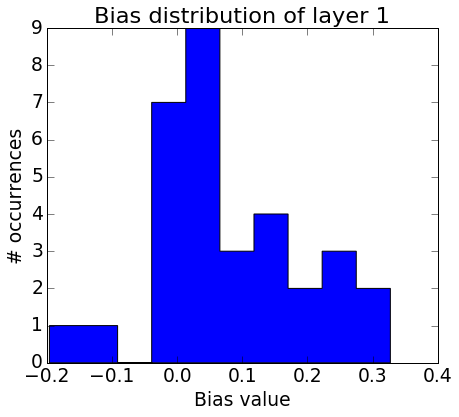

In [41]:
plt.hist(biases[1], 10, histtype='stepfilled')
plt.title("Bias distribution of layer 1")
plt.xlabel("Bias value")
plt.ylabel("# occurrences");
plt.savefig(os.path.join(path, 'distribution_b_1'), bbox_inches='tight')

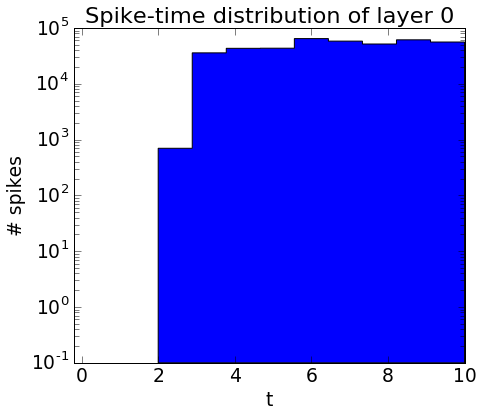

In [42]:
spikelist = [j for j in spiketrains_batch[0][0][0, :, :, :, :10].flatten() if j != 0]
plt.hist(spikelist, 9, log=True, histtype='stepfilled', bottom=0)
plt.title('Spike-time distribution of layer 0')
plt.xlabel('t')
plt.ylabel('# spikes')
plt.xlim(-0.2, None)
plt.savefig(os.path.join(path, 'distribution_spiketimes_0'), bbox_inches='tight')

# Summary

With this study we found that the convergence time of spikerates is a good measure of the transient in a network. Furthermore, the transient can be predicted based on network parameter statistics. Indicators that fail to predict well are the bias distribution, the distribution of weights averaged across feature maps, and Monte-Carlo sampled input statistics. There is also no clear correlation between the transient and the kernel size. The reason why these measures do not succeed in predicting a transient is that the convergence time of neurons in the majority of the network is highly disturbed by a great number of accumulated error sources, which makes it impossible to attribute a long convergence time to a single factor (bias, kernel size, weights...). The solution instead was to look at the very first layers, where tiny errors begin to creep in. We found that an above-threshold bias of 1.11 in combination with missing inhibitory input causes 3 extra spikes in feature map 29 of layer 2 during the first 3 steps of the simulation. This activity is widespread across most of the feature map and therefore not reduced by the following average-pooling layer 3. The feature map of layer 3 happens to be connected to the subsequent convolution layer 4 by a particularly large weight of 4.81, which amplifies the error extremely. Because the outlier weight belongs to a 1x1 kernel, there is not much other input that can help in counterbalancing the error. Therefore, each neuron in feature map 6 of layer 4 receives enough excitatory input to fire 14 extra spikes. This error contributes to further errors in the next layer. There is of course a chance that erroneous spikes from different sources balance each other out or are attenuated by small weights, but they can never exactly compensate each other or make up for all the errors that occur in a single feature map. Rather, we observe an accumulation and amplification of errors from layer to layer.

As an indicator of large transients we therefore have to consider a number of collaborating factors:
- Outliers in the bias-distribution in combination with missing spike-driven input that would later counterbalance the bias
- Outliers in the weight-distribution that amplify the effect of an erroneous spike
- 1x1 convolutions that offer little input to smooth out the effect of an erroneous spike

Experiments with random input instead of an image from the test set confirm that the above measures are independent of the input. This supports that transients could be predicted based on network parameters only.

# Modified plots for Frontiers paper

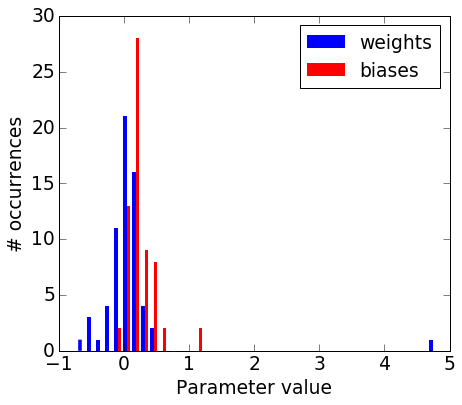

In [40]:
plt.hist([weights[3][6].flatten(), biases[2]], 40, color=['blue', 'red'], linewidth=0);
plt.xlabel("Parameter value")
plt.ylabel("# occurrences")
plt.legend(['weights', 'biases'])
plt.savefig(os.path.join(path, 'distribution'), bbox_inches='tight')